# Práctica Logs
+ Autor: Felipe David Navarro Pecci

In [1]:
# Import packages

import io
import sys
import re
import errno
import pandas as pd
import emoji
from collections import Counter
from dateutil import parser
import operator
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime

In [2]:
chat_path = r"C:\Users\fdnav\mbd_logs\Chat de WhatsApp con Master MBD.txt"

In [3]:
def replace_bad_character(line):
    return line.strip().replace(u"\u202a", "").replace(u"\u200e", "").replace(u"\u202c", "").replace(u"\xa0", " ")

try:
    with io.open(chat_path, "r", encoding="utf-8") as file:
        content = [replace_bad_character(l) for l in file.readlines()]
    
except IOError as e:
    print("Error reading the file, check the path")
    sys.exit()

In [4]:
# Display plots
%matplotlib inline

## Parseo personalizado de los datos 

Partiendo del código proporcionado, se modifica para obtener los datos en un dataframe con los siguientes campos:

+ msg_timestamp: Timestamp de cuándo se envió el mensaje
+ author: Autor del mensaje
+ msg_body: Contenido del mensaje

In [5]:
### Detectar dónde empieza cada línea del chat

"""
Starting line mean a line that started with date time.
Because there are multiline chat. I called it following line.
A starting line must be classified before it's data being extracted.
"""
def is_starting_line(line):
    pattern = r"""
        (\[?)       #Zero or one open square bracket '['
        (((\d{1,2})   #1 to 2 digit date
        (/|-)       #'/' or '-' separator
        (\d{1,2})   #1 to 2 digit month
        (/|-)       #'/' or '-' separator
        (\d{2,4}))   #2 to 4 digit of year
        (,?\s)      #Zero or one comma ',' and ingle space
        ((\d{1,2})  #1 to 2 digit of hour
        (:|\.)      #Colon ':' or dot '.' separator
        (\d{2})     #2 digit of minute
        (\.|:)?     #Zero or one of dot '.' or colon ':'
        (\d{2})?    #Zero or one of 2 digits of second
        (\s[AP]M)?))  #Zero or one of ('space', 'A' or 'P', and 'M'
        (\]?\s-?\s?\s?)#Zero or one close square bracket ']', Zero or one (space and '-'), zero or one space
        (.+)        #One or more character of chat member phone number or contact name
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), line)
    
### Detectar si una línea es un evento o un mensaje
"""
"Is Chat" means the body of a line is not an event.
May contains attachment
"""
def is_chat(body):
    pattern = r"""
            ([^:]+)#Chat member
            (:)   #Colon separator
            (.+)  #One or more charachter of message content
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), body)

### Detectar si se ha elminado un mensaje
def is_deleted(body):
    p = [
        ".*This message was deleted\.$",
        ".*Pesan ini telah dihapus$"
    ]
    
    for p in p:
        match = re.match(p, body)
        if match:
            return body
    return None

### Extraer el timestamp de un mensaje

"""
EXTRACT TIMESTAMP
"""
def extract_timestamp(time_string):
    return parser.parse(time_string)
    
# Extraer URL  
def extract_url(body):
    pattern = "https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"
    
    return re.findall(pattern, body)

## Comprobar si hay un adjunto
"""
Classify attachment
Note: in Android, there is no proper description wether it's a image, 
      video, audio, gif, or sticker.
"""
def contains_attachment(body):
    pattern_attachment = [
        ".*<Media omitted>$", #English version of android attachment
        ".*<Media tidak disertakan>$", #Indonesia version of android attachment
        ".*Pesan tidak didukung$", #Some device not recognize sticker attachment
        ".+\.vcf \(file\sterlampir\)$", #Indonesian version of android contact card,
        ".+\.vcf \(file\sattached\)$", #Indonesian version of android contact card,
        ".*image omitted$",
        ".*video omitted$",
        ".*document omitted$",
        ".*Contact card omitted$",
        ".*audio omitted$",
        ".*GIF omitted$",
        ".*sticker omitted$",
        ".*<Multimedia omitido>$"
    ]
    
    for p in pattern_attachment:
        match = re.match(p, body)
        if match:
            return body
    return None


### Parsear líneas
def parse_line(line,chat_df):
    is_starting = is_starting_line(line)
    
    if is_starting:
        #Check wether the starting line is a chat or an event
        body = is_starting.group(18)
        chat = is_chat(body)
        if chat != None:           
            has_attachment = contains_attachment(chat.group(3))
            message_body = chat.group(3)
            
            if has_attachment:
                
                return pd.DataFrame({"msg_timestamp":[],"author":[],"msg_body":[]})
                
                               
            else:
                if is_deleted(message_body):
                    
                    return pd.DataFrame({"msg_timestamp":[],"author":[],"msg_body":[]})
                else:
                    #URL & Domain
                    urls = extract_url(message_body)
                    if urls:
                        
                         return pd.DataFrame({"msg_timestamp":[],"author":[],"msg_body":[]})
                    
                    else:
                    #Add info to my DataFrame
                        autor = chat.group(1)
                        message_body = chat.group(3)
                        message_timestamp = extract_timestamp(is_starting.group(2).replace(".", ":"))
                        new_df = pd.DataFrame({"msg_timestamp":message_timestamp,"author":autor,"msg_body":message_body},index=[0])
                        return new_df
                    
        else:
            return pd.DataFrame({"msg_timestamp":[],"author":[],"msg_body":[]})
                      
    else:
        #URL & Domain
        urls = extract_url(line)
        if urls:
            return pd.DataFrame({"msg_timestamp":[],"author":[],"msg_body":[]})
        
        
        else:
            autor = chat_df["author"].iloc[-1]
            message_body = line
            message_timestamp = chat_df["msg_timestamp"].iloc[-1]
            new_df = pd.DataFrame({"msg_timestamp":message_timestamp,"author":autor,"msg_body":message_body},index=[0])
            return new_df
                
                

In [6]:
chat_df = pd.DataFrame(index=None,columns=["msg_timestamp","author","msg_body"])

In [7]:
### Parseo el contenido
for line in content:
    new_entry = parse_line(line,chat_df)
    if new_entry.empty:
        pass
    else:
        chat_df=chat_df.append(new_entry,ignore_index=True)
        


In [8]:
chat_df.head()

,msg_timestamp,author,msg_body
0,2020-09-17 19:35:00,Vicky MBD,podeis pasar el link de la clase ?
1,2020-09-17 19:35:00,Vicky MBD,por fa
2,2020-09-18 11:16:00,Maria Javierre,Podéis meter en el grupo a esta chica? Gracias!
3,2020-09-18 11:16:00,Maria Javierre,Virginia Hernández MBD.vcf (archivo adjunto)
4,2020-09-20 13:50:00,Vicky MBD,Los que tenéis mac


## Análisis de la actividad en el grupo

+ Usuarios más activos 
+ Número de mensajes por dia de la semana

Usuarios más activos en total

In [9]:
top_users = chat_df.groupby("author").count().sort_values(by="msg_body",ascending=False)

top_users["msg_count"] = top_users["msg_body"]

top_users = top_users.iloc[:10,]

top_users = top_users.drop(columns=["msg_timestamp","msg_body"])

In [10]:
top_5_users = top_users.reset_index()

top_5_users = list(top_5_users["author"])[0:5]

In [11]:
top_5_users

['Vicky MBD',
 'Fran MASTER BD',
 'Andrés Jiménez',
 'Virginia Hernández MBD',
 'Lidia Sanz']

Text(0, 0.5, 'Message Count')

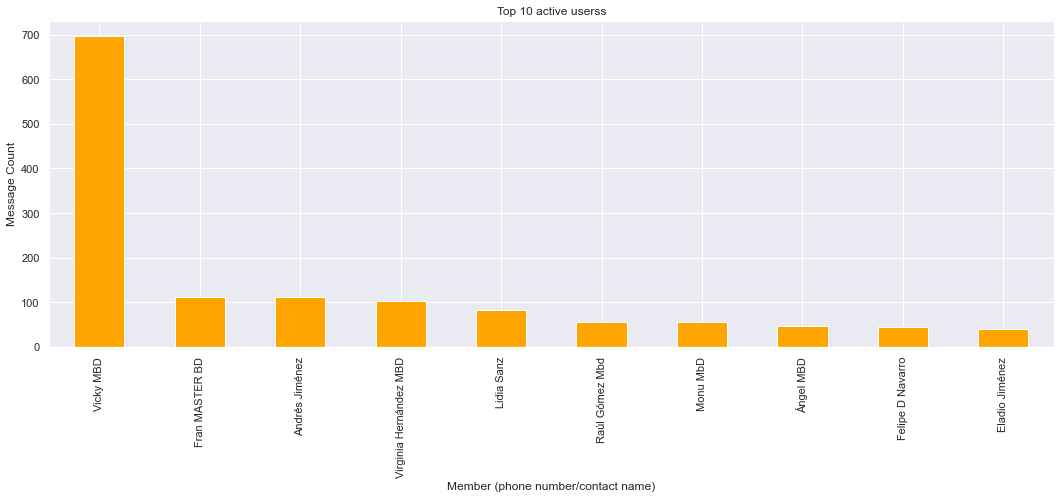

In [12]:
#top_users

sns.set()
member_plot = top_users.plot(kind='bar', legend=None, title="Top 10 active userss", figsize=(18, 6), color="orange")
member_plot.set_xlabel("Member (phone number/contact name)")
member_plot.set_ylabel("Message Count")


Número de mensajes por día de la semana

In [13]:
chat_df["weekday"] = chat_df["msg_timestamp"].apply(lambda x: x.strftime("%A"))

msg_weekday = chat_df.groupby("weekday").count()

msg_weekday = msg_weekday.reset_index()

In [14]:
msg_weekday

,weekday,msg_timestamp,author,msg_body
0,Friday,277,277,277
1,Monday,162,162,162
2,Saturday,123,123,123
3,Sunday,202,202,202
4,Thursday,234,234,234
5,Tuesday,441,441,441
6,Wednesday,469,469,469


In [15]:
msg_weekday['weekday'] = pd.Categorical(msg_weekday['weekday'], ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])

msg_weekday["msg_count"] = msg_weekday["msg_body"]

msg_weekday = msg_weekday.drop(columns=["msg_body","author","msg_timestamp"])

msg_weekday = msg_weekday.sort_values("weekday")

In [16]:
weekdays = list(msg_weekday["weekday"])

<BarContainer object of 7 artists>

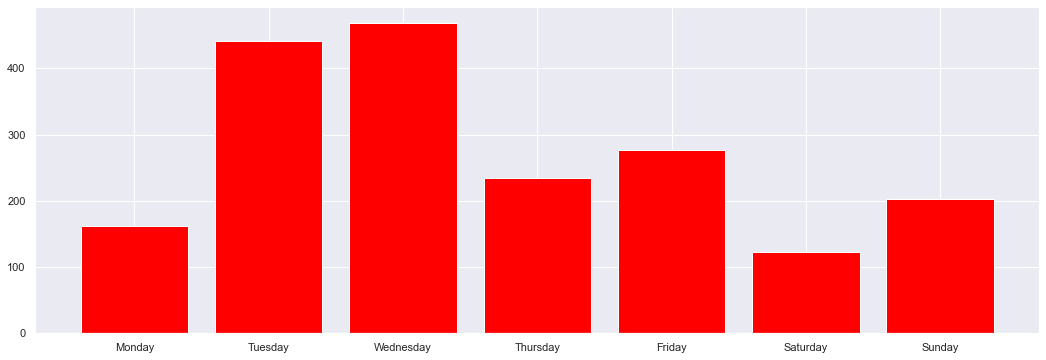

In [17]:
fig = plt.figure(figsize=(18, 6)) 

plt.bar(msg_weekday["weekday"],msg_weekday["msg_count"], color="red")

Los martes y miércoles son los días más activos en el grupo, mientras que el sábado es el día de menor actividad

# Análisis de sentimiento

In [23]:
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob

import string

## Limpieza de los datos

Se va a realizar un análisis de sentimiento sencillo, para ello se hacen las siguientes transformaciones al texto de los mensajes:

+ Pasar todo el texto a minúsculas
+ Quitar signos de puntuación
+ Quitar espacios, saltos de línea y tabulaciones
+ Quitar palabras que contengan números

Para el análisis de sentimiento se utiliza la librería textblob. Esta librería sólo permite trabajar en inglés, pero incorpora una API para traducir el texto
utilizando google translate.

Con esta librería se va a medir la polaridad (valores más grandes significan más positivo) y la subjetividad (valores más grandes significan más subjetividad)

In [24]:
def limpiar_datos(texto):
    texto = texto.lower()
    texto = re.sub('\[.*?¿\]\%', ' ', texto)
    texto = re.sub('[%s]' % re.escape(string.punctuation), ' ', texto)
    texto = re.sub('\w*\d\w*', '', texto)
    texto = re.sub('[‘’“”…«»]', '', texto)
    texto = re.sub('\n', ' ', texto)
    return texto

In [25]:
sw_spanish = stopwords.words('spanish')

In [26]:
# Añado un par de stopwords custom

sw_spanish = sw_spanish + ["gracias","si"]

Funciones para tratar mi texto

In [27]:
polaridad = lambda x: x.sentiment.polarity
subjetividad = lambda x: x.sentiment.subjectivity
traducir = lambda x: TextBlob(x).translate(to="en")

## Análisis de sentimiento por día de la semana

In [28]:
chat_df["weekday"] = chat_df["msg_timestamp"].apply(lambda x: x.strftime("%A"))

chat_weekday = chat_df.drop(columns=["author","msg_timestamp"])

In [29]:
chat_weekday["msg_body"] = chat_weekday.groupby("weekday")["msg_body"].transform(lambda x:  " ".join(x))

In [30]:
chat_weekday = chat_weekday.drop_duplicates()

In [31]:
chat_weekday = chat_weekday.set_index("weekday")

In [32]:
chat_weekday = pd.DataFrame(chat_weekday["msg_body"].apply(lambda x: limpiar_datos(x)))

In [33]:
chat_weekday = chat_weekday.reset_index()

In [34]:
chat_weekday['weekday'] = pd.Categorical(chat_weekday['weekday'], ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])

chat_weekday = chat_weekday.sort_values("weekday")

chat_weekday = chat_weekday.set_index("weekday")

#### Wordcloud por día de la semana

In [35]:
wc = WordCloud(stopwords=sw_spanish, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [36]:
plt.rcParams['figure.figsize'] = [20,18]

In [37]:
chat_weekday_tr = chat_weekday.transpose()

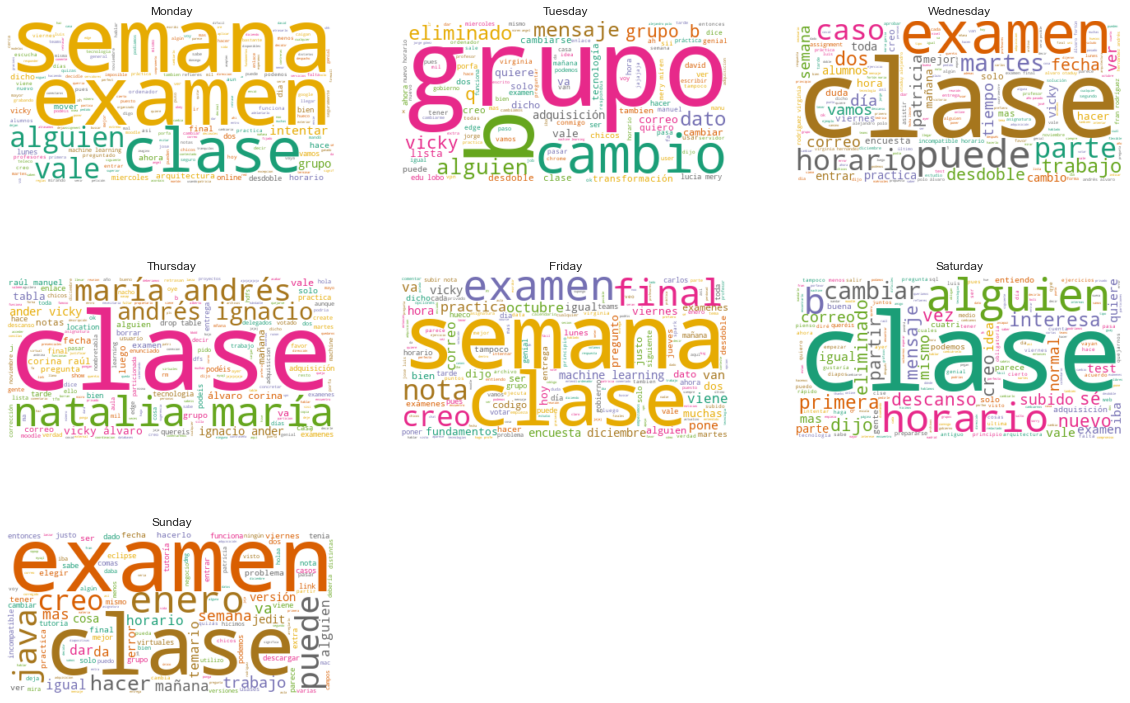

In [38]:
for index, day in enumerate(chat_weekday_tr.columns):
    wc.generate(chat_weekday.msg_body[day])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(weekdays[index])
plt.show()

Las palabras no cambian mucho por cada día de la semana, parece que la temática es más o menos la misma

#### Traducimos y tratamos los mensajes para el análisis de sentimiento

In [39]:
chat_weekday["blob_en"] = chat_weekday["msg_body"].apply(traducir)

In [40]:
chat_weekday['pol'] = chat_weekday['blob_en'].apply(polaridad)
chat_weekday['subje'] = chat_weekday['blob_en'].apply(subjetividad)

In [41]:
chat_weekday = chat_weekday.reset_index()

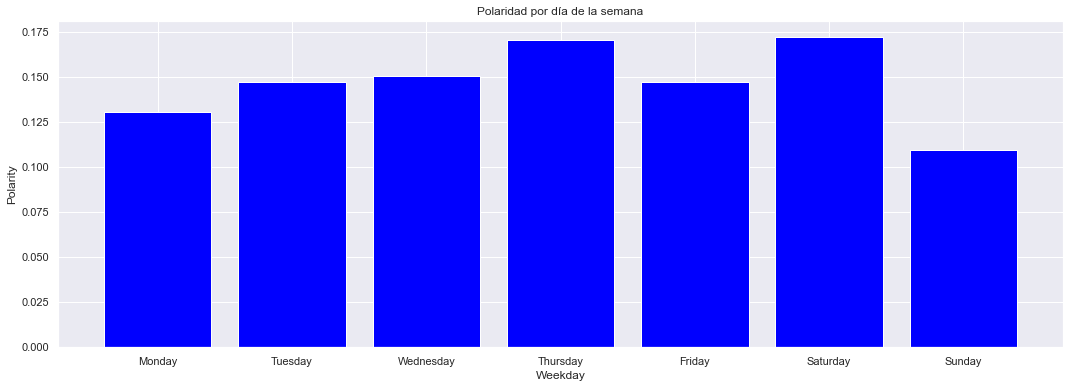

In [42]:
fig = plt.figure(figsize=(18, 6)) 

plt.bar(chat_weekday["weekday"],chat_weekday["pol"], color="blue")
plt.xlabel("Weekday") 
plt.ylabel("Polarity") 
plt.title("Polaridad por día de la semana") 
plt.show() 


Parece que el Domingo y el Lunes son los días con un sentimiento menos positivo, mientras que el Jueves y el Sábado son los días con mensajes más positivos. 

No obstante, la polaridad es predominantemente positiva todos los días.

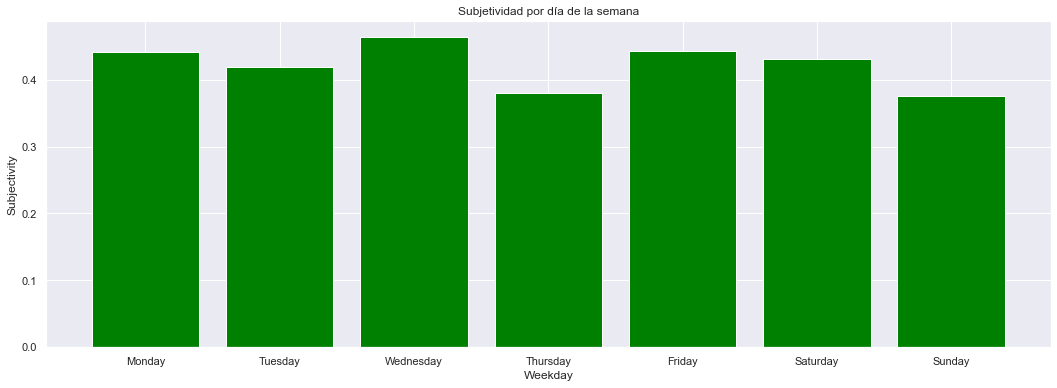

In [43]:
fig = plt.figure(figsize=(18, 6)) 

plt.bar(chat_weekday["weekday"],chat_weekday["subje"], color="green")
plt.xlabel("Weekday") 
plt.ylabel("Subjectivity") 
plt.title("Subjetividad por día de la semana") 
plt.show() 


Parece que todos los días los mensajes son bastante subjetivos (más opiniones que hechos), siendo el Jueves el día con una subjetividad más baja.

## Análisis de sentimiento por usuario

In [44]:
chat_user = chat_df.drop(columns=["msg_timestamp","weekday"])

In [45]:
chat_user["msg_body"] = chat_user.groupby("author")["msg_body"].transform(lambda x:  " ".join(x))

chat_user = chat_user.drop_duplicates()

In [46]:
chat_user = chat_user[chat_user["author"].apply(lambda x: x in top_5_users)]

In [47]:
chat_user = chat_user.set_index("author")

In [48]:
chat_user = pd.DataFrame(chat_user["msg_body"].apply(lambda x: limpiar_datos(x)))

In [49]:
chat_user = chat_user.reset_index()

chat_user['author'] = pd.Categorical(chat_user['author'], top_5_users)

chat_user = chat_user.sort_values("author")

chat_user = chat_user.set_index("author")

#### Wordcloud por autor

In [50]:
wc = WordCloud(stopwords=sw_spanish, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [51]:
plt.rcParams['figure.figsize'] = [25,20]

In [52]:
chat_user_tr = chat_user.transpose()

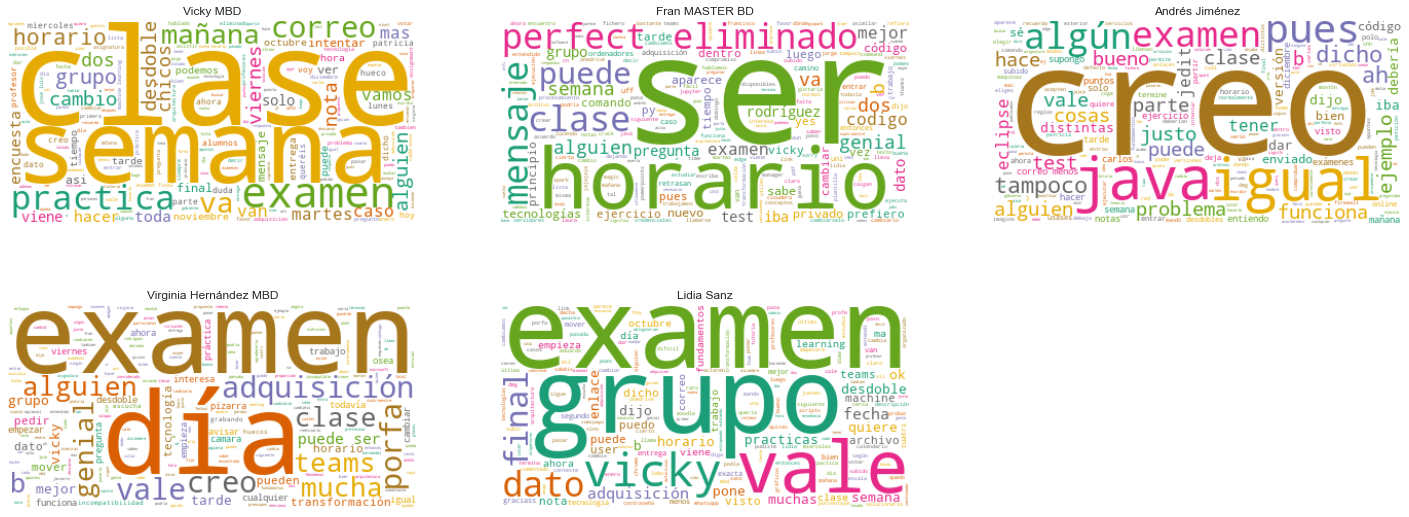

In [53]:
for index, user in enumerate(chat_user_tr.columns):
    wc.generate(chat_user.msg_body[user])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(top_5_users[index])
plt.show()

#### Traducimos y tratamos los mensajes para el análisis de sentimiento

In [54]:
chat_user["blob_en"] = chat_user["msg_body"].apply(traducir)
chat_user['pol'] = chat_user['blob_en'].apply(polaridad)
chat_user['subje'] = chat_user['blob_en'].apply(subjetividad)

In [55]:
chat_user = chat_user.reset_index()

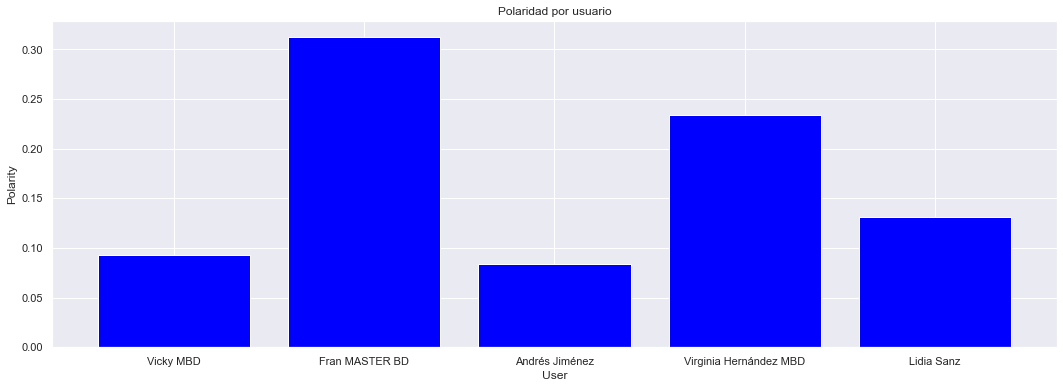

In [56]:
fig = plt.figure(figsize=(18, 6)) 

plt.bar(chat_user["author"],chat_user["pol"], color="blue")
plt.xlabel("User") 
plt.ylabel("Polarity") 
plt.title("Polaridad por usuario") 
plt.show() 

Todos los usuarios presentan una polaridad positiva, pero tanto Fran como Virginia muestran una polaridad muy superior al resto de los usuarios en el top 5 de usuarios más activos.

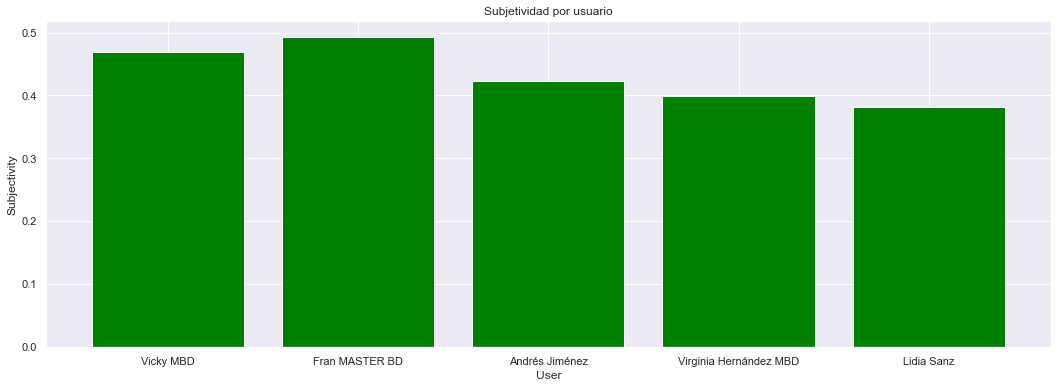

In [57]:
fig = plt.figure(figsize=(18, 6)) 

plt.bar(chat_user["author"],chat_user["subje"], color="green")
plt.xlabel("User") 
plt.ylabel("Subjectivity") 
plt.title("Subjetividad por usuario") 
plt.show() 

Todos los usuarios presenta una subjetividad positiva, lo que indica que sus mensajes tienden más a ser opiniones que mensajes meramente informativos